![pymt](https://github.com/csdms/pymt/raw/master/docs/_static/pymt-logo-header-text.png)

## CHILD Landscape Evolution Model
* Link to this notebook: https://github.com/csdms/pymt-live/blob/master/nb/child.ipynb
* Install command: `$ conda install notebook pymt_child`



Import the `Child` component from `pymt`. All of the components available to `pymt` are located in `pymt.models`. If you haven't already installed `Child` as a *pymt* component, you'll have to do so first. You can do this with `conda`,

    $ conda install pymt_child -c conda-forge

In [1]:
# Some magic to make plots appear within the notebook
%matplotlib inline

import numpy as np # In case we need to use numpy

### Run CHILD in PyMT

As with all *pymt* components, we start by importing and instantiating the model class.

In [2]:
import pymt.models

child = pymt.models.Child()

➡ models: FrostNumber, Ku, ExponentialWeatherer, Flexure, FlowAccumulator, FlowDirectorD8, FlowDirectorDINF, FlowDirectorSteepest, FlowRouter, LinearDiffuser, OverlandFlow, SoilMoisture, StreamPowerEroder, TransportLengthHillslopeDiffuser, Vegetation, Hydrotrend, Child, Cem, Waves


You can now see the help information for Child. Have a look under the *Parameters* section (you may have to scroll down - it's the section after the citations). The *Parameters* section describes optional keywords that you can pass the the `setup` method. In the previous examples we may have just used defaults. Below we'll see how to set input file parameters programmatically through keywords.

In [3]:
help(child)

Help on Child in module pymt.framework.bmi_bridge object:

class Child(BmiCap)
 |  Basic Model Interface for child.
 |  
 |  CHILD computes the time evolution of a topographic surface z(x,y,t) by
 |  fluvial and hillslope erosion and sediment transport.
 |  
 |  Author:
 |  - Greg Tucker
 |  - Stephen Lancaster
 |  - Nicole Gasparini
 |  - Rafael Bras
 |  - Scott Rybarczyk
 |  Version: 10.6
 |  License: GPLv2
 |  DOI: 10.1594/IEDA/100102
 |  URL: http://csdms.colorado.edu/wiki/Model:CHILD
 |  
 |  Cite as:
 |  
 |      @article{tucker2010child,
 |        title={CHILD Users Guide for version R9. 4.1},
 |        author={Tucker, Gregory E},
 |        journal={Cooperative Institute for Research in Environmental Sciences (CIRES) and Department of Geological Sciences, University of Colorado, Boulder, USA},
 |        year={2010}
 |      }
 |  
 |      @article{tucker2001object,
 |        title={An object-oriented framework for distributed hydrologic and geomorphic modeling using triangulated 

We can change input file paramters through `setup` keywords. The `help` description above gives a brief description of each of these. For this example we'll change the grid spacing, the size of the domain, and the duration of the simulation.

In [5]:
config_file, initdir = child.setup(
    "_child",
    grid_node_spacing=750.,
    grid_x_size=20000.,
    grid_y_size=40000.,
    run_duration=1e6,
)

The setup folder now only contains the child input file.

In [6]:
ls _child

child.in


Again, initialize and run the model for 10 time steps.

In [7]:
child.initialize(config_file, initdir)

In [8]:
for t in range(10):
    child.update()
    print(child.time)

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


We can check in the time units in the usual way.

In [10]:
child.time_units

'year'

Update until some time in the future. Notice that, in this case, we update to a partial time step. Child is fine with this however some other models may not be. For models that can not update to times that are not full time steps, *pymt* will advance to the next time step and interpolate values to the requested time.

In [11]:
child.update_until(201.5, units='year')
print(child.time)

201.5


Child provides several output variables, which we get in the usual way.

In [12]:
child.output_var_names

('land_surface__elevation',
 'sea_bottom_surface__elevation',
 'land_surface__elevation_increment',
 'sediment__erosion_rate',
 'channel_water__discharge',
 'channel_water_sediment~bedload__mass_flow_rate')

In [13]:
child.get_value('land_surface__elevation')

array([ 0.        ,  0.        ,  0.        , ..., -0.14213881,
       -0.34210564,  0.00178402])

We can query each input and output variable. *pymt* attaches a dictionary to each component called `var` that provides information about each variable. For instance we can see that `"land_surface__elevation"` has units of meters, is an input and output variable, and is defined on the nodes of grid with id 0.

In [16]:
child.var['land_surface__elevation']

<DataValues>
double land_surface__elevation(node)
Attributes:
    units: m
    grid: 0
    intent: inout
    location: node

If we plot this variable, we can visually see the unsructured triangular grid that Child has decomposed its grid into.

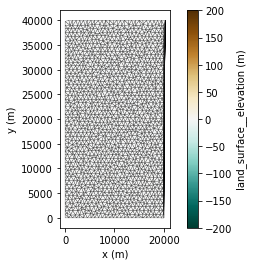

In [18]:
child.quick_plot(
    "land_surface__elevation",
    edgecolors="k",
    vmin=-200,
    vmax=200,
    cmap="BrBG_r",
)

As with the `var` attribute, *pymt* adds a dictionary, called `grid`, to components that provides a description of each of the model's grids. Here we can see how the x and y positions of each grid node, and how nodes connect to one another to form faces (the triangles in this case). Grids are described using the ugrid conventions.

In [19]:
child.grid[0]

<xarray.Dataset>
Dimensions:                 (face: 2914, node: 1512, vertex: 8742)
Dimensions without coordinates: face, node, vertex
Data variables:
    mesh                    int64 0
    node_x                  (node) float64 750.0 1.5e+03 ... 1.939e+04 1.96e+04
    node_y                  (node) float64 0.0 0.0 0.0 ... 3.839e+04 3.883e+04
    face_node_connectivity  (vertex) int32 211 106 107 210 107 ... 79 80 78 79
    face_node_offset        (face) int64 3 6 9 12 15 ... 8733 8736 8739 8742

Child initializes it's elevations with random noise centered around 0. We would like instead to give it elevations that have some land and some sea. First we'll get the x and y coordinates for each node along with their elevations.

In [20]:
x, y = child.grid_x(0), child.grid_y(0)
z = child.get_value('land_surface__elevation')

All nodes above `y=y_shore` will be land, and all nodes below `y=y_shore` will be sea.

In [21]:
y_shore = 15000.
z[y < y_shore] -= 100
z[y >= y_shore] += 100

In [23]:
child.set_value("land_surface__elevation", z)

array([-100.        , -100.        , -100.        , ...,   99.85786119,
         99.65789436,  100.00178402])

Just to verify we set things up correctly, we'll create a plot.

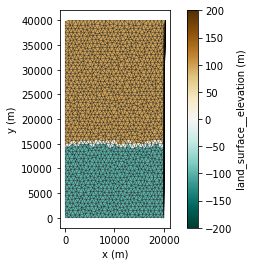

In [24]:
child.quick_plot(
    "land_surface__elevation",
    edgecolors="k",
    vmin=-200,
    vmax=200,
    cmap="BrBG_r",
)

To get things going, we'll run the model for 5000 years and see what things look like.

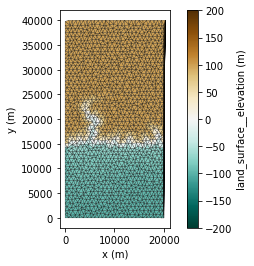

In [26]:
child.update_until(5000.)
child.quick_plot(
    "land_surface__elevation",
    edgecolors="k",
    vmin=-200,
    vmax=200,
    cmap="BrBG_r",
)

We'll have some fun now by adding a simple uplift component. We'll run the component for another 5000 years but this time uplifting a corner of the grid by `dz_dt`.

In [27]:
dz_dt = .02
now = child.time
times, dt = np.linspace(now, now + 5000., 50, retstep=True)
for time in times:
    child.update_until(time)
    z = child.get_value("land_surface__elevation")
    z[(y > 15000.) & (x > 10000.)] += dz_dt * dt
    child.set_value("land_surface__elevation", z)

A portion of the grid was uplifted and channels have begun eroding into it.

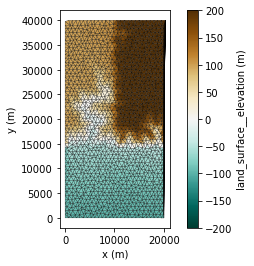

In [28]:
child.quick_plot(
    "land_surface__elevation",
    edgecolors='k',
    vmin=-200,
    vmax=200,
    cmap="BrBG_r",
)

We now stop the uplift and run it for an additional 5000 years.

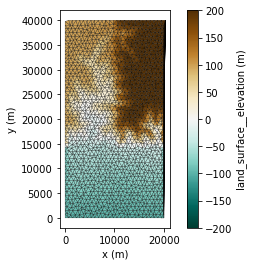

In [30]:
child.update_until(child.time + 5000.)
child.quick_plot(
    "land_surface__elevation",
    edgecolors="k",
    vmin=-200,
    vmax=200,
    cmap="BrBG_r",
)